In [11]:
#if True then working on the DCC repo, with cosmosis enabled
#if False then working on local repo. no cosmosis
REMOTE_COSMOSIS_FLAG = True 

import os,sys,inspect
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.integrate as intg
import pandas as pd

#import modules from parent directory
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from interpolation_fncs import *
from io_fncs import *
from gal_distr import *
from basic_cosmo_lensing_fncs import *
from limber_integral import *

if REMOTE_COSMOSIS_FLAG == True:
    import fitsio as fio

########################################
#io
########################################

outputfolder       = 'run0'
if REMOTE_COSMOSIS_FLAG == True:
    outputparentfolder = '/hpc/group/cosmology/alanzhou/IA-Project/IA-Self-Calib-Data/'
    outputpath         = os.path.join(outputparentfolder, outputfolder)
    create_dir(outputpath)
if REMOTE_COSMOSIS_FLAG == False:
    outputparentfolder = '/Users/junzhezhou/Desktop/Cosmology Indep Study/IA-Self-Calib-Data/'
    outputpath         = os.path.join(outputparentfolder, outputfolder)
    create_dir(outputpath)
    
########################################
#constants
########################################
h0 = 67.26       #H0 (km/s/Mpc)
d_horiz = 299792.458/h0 #c/H0, c in km/s
Omega0 = 0.3141 #present day matter density in unit of critical density
OmegaLambda = 1-0.3141
Omegak = 1-Omega0-OmegaLambda
deltaz = 0.2 #redshift bin width
#in integration 1 redshift is broken into z_res intervals
#for z_max = 4, zres = 400 ~20sec/run
z_bin_num = 20
z_max = z_bin_num*deltaz+2 #+2 redshift reserved for photometric error
z_res = 100 

save_config_file(os.path.join(outputpath,'values.txt'),
                 ['Identifier',outputfolder,
                  'h0, [km/s/Mpc]',h0,
                  'horizon distance = c/h0, [Mpc]',d_horiz,
                  'Omega0',Omega0,
                  'OmegaLambda',OmegaLambda,
                  'Omegak',Omegak,
                  'deltaz',deltaz,
                  'z_bin_num',z_bin_num,
                  'z_max',z_max,
                  'z_res',z_res,
                  'z_res_spacing',1/z_res])

print(' - Setup complete. z resolution is %1.5f' %(1/z_res))

########################################
#Pre-CosmoSIS Calculations
########################################

#get the galaxy distribution
print(' - Getting the galaxy distribution, assuming '+'z2exp_gausPDF')
[photo_z_file,true_z_file] = get_gal_distr(z_bin_num,deltaz,z_res,z_max,'z2exp_gausPDF',outputpath,REMOTE_COSMOSIS_FLAG);
z_list = photo_z_file['Z_MID']

#get cmv distance and lensing kernel (unit = Mpc)
#get integrated lensing kernel W_i(z_L) for each redsfhit bin (Zhang 2010 A2)
print(' - Computing cmv dists, W_L, and integrated lensing kernels W_i')
[chi_list,W_L_list] = get_basic_cosmo_lensing(d_horiz,Omega0,OmegaLambda,Omegak,z_list,outputpath); #in Mpc unit
W_i = get_integrated_lensing_kernel(W_L_list,true_z_file,z_list,z_bin_num,outputpath)

########################################
#Load CosmoSIS Output
########################################

#run the matter_pow.ini with CosmoSIS from terminal
#this generates the P(k,z), and the regular C_Gg spectra
print(' - Assuming CosmoSIS has being ran. Loading CosmoSIS output.')

#load the C_GG in angular space from CosmoSIS (shear-shear option)
print('   - Loading C_GG(ell) from CosmoSIS')
shear_cl_folder = os.path.join(outputpath,'cosmoSIS_output/shear_cl')
with open(os.path.join(shear_cl_folder,'ell.txt'),'rb') as f:
    ell_list = np.loadtxt(f)
C_GG_ii = np.empty((z_bin_num,len(ell_list)))
plt.subplots(figsize=(6,6))
for i in range(z_bin_num):
    with open(os.path.join(shear_cl_folder,'bin_%i_%i.txt'%(i+1,i+1)),'rb') as f:
        C_GG_ii[i] = np.loadtxt(f)
    plt.plot(ell_list,C_GG_ii[i],label='C_GG_ii, i=%i'%(i+1))
plt.xlabel('ell')
plt.ylabel('C_GG_ii')
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1, 0),loc='lower left') #bbox(x,y)
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'combined_C_GG_ii.png'))
#plt.show()
plt.close()

#load the C_Gg in angular space from CosmoSIS (position-shear option)
print('   - Loading C_Gg(ell) from CosmoSIS')
galaxy_shear_cl_folder = os.path.join(outputpath,'cosmoSIS_output/galaxy_shear_cl')
with open(os.path.join(galaxy_shear_cl_folder,'ell.txt'),'rb') as f:
    ell_list = np.loadtxt(f)
C_Gg_ii = np.empty((z_bin_num,len(ell_list)))
plt.subplots(figsize=(6,6))
for i in range(z_bin_num):
    with open(os.path.join(galaxy_shear_cl_folder,'bin_%i_%i.txt'%(i+1,i+1)),'rb') as f:
        C_Gg_ii[i] = np.loadtxt(f)
    plt.plot(ell_list,C_Gg_ii[i],label='C_Gg_ii, i=%i'%(i+1))
plt.xlabel('ell')
plt.ylabel('C_Gg_ii')
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1, 0),loc='lower left') #bbox(x,y)
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'combined_C_Gg_ii.png'))
#plt.show()
plt.close()

#load the C_gg in angular space from CosmoSIS (position-position option)
print('   - Loading C_gg(ell) from CosmoSIS')
galaxy_cl_folder = os.path.join(outputpath,'cosmoSIS_output/galaxy_cl')
with open(os.path.join(galaxy_cl_folder,'ell.txt'),'rb') as f:
    ell_list = np.loadtxt(f)
C_gg_ii = np.empty((z_bin_num,len(ell_list)))
plt.subplots(figsize=(6,6))
for i in range(z_bin_num):
    with open(os.path.join(galaxy_cl_folder,'bin_%i_%i.txt'%(i+1,i+1)),'rb') as f:
        C_gg_ii[i] = np.loadtxt(f)
    plt.plot(ell_list,C_gg_ii[i],label='C_gg_ii, i=%i'%(i+1))
plt.xlabel('ell')
plt.ylabel('C_gg_ii')
plt.xscale('log')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1, 0),loc='lower left') #bbox(x,y)
plt.tight_layout()
plt.savefig(os.path.join(outputpath,'combined_C_gg_ii.png'))
#plt.show()
plt.close()

#get the power spectrum P(k,z) from CosmoSIS. (need non-linear spectrum)
#convert to Del^2_mg (CHEKCKED)
#matter_pow_p_k[z_index,kindex]
#Del^2_mg is represented by the variable Del_mg 
#Del^2_mg(k,z) = k^3 P(k,z) / (2 pi^2)
print('   - Loading P(k,z) from CosmoSIS. Converting it to Del^2_mg(k,z)')
matter_power_folder = os.path.join(outputpath,'cosmoSIS_output/matter_power_nl')
with open(os.path.join(matter_power_folder, 'p_k.txt'),'rb') as f:
    matter_pow_p_k = np.loadtxt(f,delimiter = ' ') 
with open(os.path.join(matter_power_folder, 'k_h.txt'),'rb') as f:
    matter_pow_k_h = np.loadtxt(f,delimiter = ' ')
with open(os.path.join(matter_power_folder, 'z.txt'),'rb') as f:
    matter_pow_z = np.loadtxt(f,delimiter = ' ')

########################################
#Post-CosmoSIS Calculations
########################################
    
Del_mg = np.empty(matter_pow_p_k.shape)
for z_index in range(len(matter_pow_z)):
    Del_mg[z_index] = (matter_pow_k_h**3)*matter_pow_p_k[z_index]/(2*np.pi)

#interpolate Del_mg so that it has the same z axis as chi, W_i, and galaxy distributions
print(' - Interpolating Del^2_mg(k,z) for further calculations')
Del_mg_interpolated = interpolate_2d(Del_mg,matter_pow_z,matter_pow_k_h,z_list,matter_pow_k_h)


 - Setup complete. z resolution is 0.01000
 - Getting the galaxy distribution, assuming z2exp_gausPDF
 - Computing cmv dists, W_L, and integrated lensing kernels W_i
 - Assuming CosmoSIS has being ran. Loading CosmoSIS output.
   - Loading C_GG(ell) from CosmoSIS
   - Loading C_Gg(ell) from CosmoSIS
   - Loading C_gg(ell) from CosmoSIS
   - Loading P(k,z) from CosmoSIS. Converting it to Del^2_mg(k,z)
 - Interpolating Del^2_mg(k,z) for further calculations


 - Bin of interest = 1, z = 0.000-0.200
 - Bin of interest = 2, z = 0.200-0.400
 - Bin of interest = 3, z = 0.400-0.600
 - Bin of interest = 4, z = 0.600-0.800
 - Bin of interest = 5, z = 0.800-1.000
 - Bin of interest = 6, z = 1.000-1.200
 - Bin of interest = 7, z = 1.200-1.400
 - Bin of interest = 8, z = 1.400-1.600
 - Bin of interest = 9, z = 1.600-1.800
 - Bin of interest = 10, z = 1.800-2.000
 - Bin of interest = 11, z = 2.000-2.200
 - Bin of interest = 12, z = 2.200-2.400
 - Bin of interest = 13, z = 2.400-2.600
 - Bin of interest = 14, z = 2.600-2.800
 - Bin of interest = 15, z = 2.800-3.000
 - Bin of interest = 16, z = 3.000-3.200
 - Bin of interest = 17, z = 3.200-3.400
 - Bin of interest = 18, z = 3.400-3.600
 - Bin of interest = 19, z = 3.600-3.800
 - Bin of interest = 20, z = 3.800-4.000


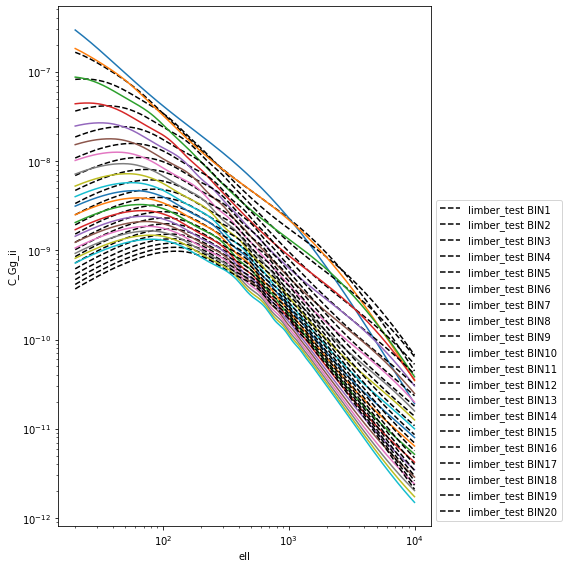

In [16]:
#set the bin of interest
# BOI = 1
# print(' - Bin of interest = %i, z = %1.3f-%1.3f'%(BOI,(BOI-1)*deltaz,BOI*deltaz))
# #the weight that goes into the limber integral as a function of z
# limber_weight = chi_list*W_i[BOI-1]*true_z_file['BIN%i'%(BOI)]
# limber_test=limber_integral(Del_mg_interpolated,limber_weight,chi_list,matter_pow_k_h,z_list,ell_list)
# plt.subplots(figsize=(6,6))
# plt.plot(ell_list,limber_test,color='black',linestyle='dashed',label='limber_test BIN%i'%(BOI))
plt.subplots(figsize=(8,8))
for i in range(z_bin_num):
    BOI = i+1
    print(' - Bin of interest = %i, z = %1.3f-%1.3f'%(BOI,(BOI-1)*deltaz,BOI*deltaz))
    #the weight that goes into the limber integral as a function of z
    limber_weight = chi_list*W_i[BOI-1]*true_z_file['BIN%i'%(BOI)]
    limber_test=limber_integral(Del_mg_interpolated,limber_weight,chi_list,matter_pow_k_h,z_list,ell_list)

    plt.plot(ell_list,limber_test,color='black',linestyle='dashed',label='limber_test BIN%i'%(BOI))
    plt.plot(ell_list,C_Gg_ii[i])#label='C_Gg_ii, i=%i'%(i+1)

plt.xlabel('ell')
plt.ylabel('C_Gg_ii')
plt.xscale('log')
plt.yscale('log')
# plt.xlim(10,10000)
# plt.ylim(10**(-12),10**(1))
plt.legend(bbox_to_anchor=(1, 0),loc='lower left') #bbox(x,y)
plt.tight_layout()
plt.show()

#print(limber_test)

In [43]:
from scipy import interpolate
temp_x = [0.01,0.02,0.03,0.04,0.1,0.2,0.3,0.4]
temp_y = np.ones(len(temp_x))

temp_func = interpolate.interp1d(temp_x,temp_y,bounds_error=False,fill_value=0)
test_x = [0.0001,0.0005,0.01,0.02,0.03,0.04,0.1,0.2,0.3,0.4,0.5]
temp_func(test_x)


array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.])

In [6]:
#Input matter density spectrum Del_mg[l,z]
Del_l_list = np.logspace(2,4,num=20) #log scale from 10^2 to 10^4
#Del_z_list should be set to = z_list
#throw away the first element to perform right Riemann sum to avoid 0 division
z_list = np.linspace(0,z_max,z_max*z_res,dtype='float64')[1:]
Del_mg = np.ones((len(Del_l_list),len(z_list)))

def get_Q_function(i,Del_mg,Del_l_list,z_list):
    "get the Q function for the ith redshift bin. (i>=0)"

    ################################################
    #get the Q fnc for a single redshift bin
    ################################################
    z_i_center = deltaz*(i+0.5) #the center for the ith redshift bin
    z_lowerbound = z_i_center-deltaz/2
    z_upperbound = z_i_center+deltaz/2
    #i = 1 -> 0-0.2
    #i = 3 -> 0.4-0.6
    #i = 6 -> 1.0-1.2
    #i = 9 -> 1.8-2.0
    
    print("calculating for redshift bin %1.2f - %1.2f" %(z_lowerbound,z_upperbound))

    ################################################
    #Setups - Calculating related functions
    ################################################

    #Redshift coordinates
    #throw away the first element to perform right Riemann sum to avoid 0 division
    z_i_list = np.linspace(z_lowerbound,z_upperbound,int(deltaz*z_res),dtype='float64')[1:]

    #Gaussian Photo-Z PDF bin i
    photozPDF = np.empty((len(z_list),len(z_i_list)),dtype='float64')
    for ztrue_index in range(len(z_list)):
        ztrue = z_list[ztrue_index]
        #std function as a linear in redshift
        #Zhang 2010 discusses when 0.05->0.03 accuracy improves by 2.3x on page 7 bottom right
        std = gaussian_spread*(1+ztrue)
        #gaussian pdf
        prefector = 1/(np.sqrt(2*np.pi)*std)
        photozPDF[ztrue_index] = prefector*np.exp(-0.5*((z_i_list-ztrue)/std)**2)
#     test_redshift_index=int(1.25*z_res)
#     plt.plot(z_i_list, photozPDF[test_redshift_index],label='area under the curve=%1.3f'%(sum(photozPDF[test_redshift_index]/z_res)))
#     plt.xlabel('redshift z')
#     plt.ylabel('photo_z PDF around z_true=%1.4f, \n with sigma_p=%1.3f' %(z_list[test_redshift_index],gaussian_spread))
#     plt.show()

    #galaxy photo z distribution
    def n(z):
        return z*z*np.exp(-z/0.5)

    #galaxy photo z distribution normalized in bin i
    n_photo_i_norm = intg.quad(n,z_lowerbound,z_upperbound)[0]
    def n_photo_i(z):
        return z*z*np.exp(-z/0.5)/n_photo_i_norm
    n_photo_i_list = n_photo_i(z_i_list)

    #galaxy photo z distribution normalized from 0 to infinity=z_max
    n_photo_all_norm = intg.quad(n,0,z_max)[0]
    def n_photo_all(z):
        return z*z*np.exp(-z/0.5)/n_photo_all_norm
    n_photo_all_list = n_photo_all(z_list)

    #galaxy true z distribution (photo z distribution + smear) normalized from 0 to infinity=z_max
    n_i_list = np.zeros(len(z_list))
    z_i_list_index = 0
    for ztrue in z_i_list:
        std = gaussian_spread*(1+ztrue)
        prefector = 1/(np.sqrt(2*np.pi)*std)
        n_i_list += n_photo_i_list[z_i_list_index]*prefector*np.exp(-0.5*((z_list-ztrue)/std)**2)
        z_i_list_index += 1
    n_i_list_norm = sum(n_i_list)/z_res
    n_i_list = n_i_list/n_i_list_norm

    #galaxy true z distribution (photo z distribution + smear) normalized in bin i
    n_i_bin_list = np.zeros(len(z_i_list))
    z_i_list_index = 0
    for ztrue in z_i_list:
        std = gaussian_spread*(1+ztrue)
        prefector = 1/(np.sqrt(2*np.pi)*std)
        n_i_bin_list += n_photo_i_list[z_i_list_index]*prefector*np.exp(-0.5*((z_i_list-ztrue)/std)**2)
        z_i_list_index += 1
    n_i_bin_list_norm = sum(n_i_bin_list)/z_res
    n_i_bin_list = n_i_bin_list/n_i_bin_list_norm

#     plt.plot(z_list, n_photo_all_list,linestyle='dashed',label = 'n_photo_all_list (photoz) normalized from z=0 to z=inf=z_max')
#     plt.plot(z_list, n_i_list,label = 'n_i_list (truez) normalized from z=0 to z=inf=z_max')
#     plt.plot(z_i_list, n_photo_i_list,linestyle='dashed',label = 'n_z_i_list (photoz) truncated and normalized in the %1i th redshift bin'%i)
#     plt.plot(z_i_list, n_i_bin_list,label = 'n_i_bin_list (truez) truncated and normalized in the %1i th redshift bin'%i)
#     plt.xlabel('redshift z')
#     plt.ylabel('galaxy redshift distribution')
#     plt.legend(bbox_to_anchor=(1, 1.05))
#     plt.show()

    #Integrated kernel, Zhang 2010 (A2)
    W_i = np.empty(len(z_list))
    for z_L_index in range(len(z_list)):
        W_i[z_L_index] = sum(W_L_list[z_L_index]*n_i_list)/z_res #using the true redshift distribution
#     plt.plot(z_list, W_i)
#     plt.xlabel('redshift z')
#     plt.ylabel('W_i for the %1i th redshift bin'%i)
#     plt.show()

    ################################################
    #Main Calculation integration (Zhang 2010, Appendix B)
    ################################################

    eta = 0
    eta_z = np.empty(len(z_list),dtype='float64')
    ui = np.empty(len(z_list),dtype='float64')
    li = np.empty(len(z_list),dtype='float64')

    for z_index in range(len(z_list)):#[int(1.2*z_res)]
        ################
        #Upper integral with out multiplying the volume element (canceled out when dividing)
        #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P)*S(z_G^P,z_g^P) #indices: (z_G^P,z_g^P)
        psnn_zGP = np.empty(len(z_i_list),dtype='float64')
        Wppsnn_2D = np.empty((len(z_list),len(z_i_list)),dtype='float64') 
        #Lower integral with out multiplying the volume element (canceled out when dividing)
        #the matrix corr. to p(z,z_g^P)*n_i^P(z_G^P)*n_i^P(z_g^P) #indices: (z_G^P,z_g^P)
        pnn_zGP = np.empty(len(z_i_list),dtype='float64')
        Wppnn_2D = np.empty((len(z_list),len(z_i_list)),dtype='float64') 

        for zGP_index in range(len(z_i_list)):
            filterfunction = z_i_list-z_i_list[zGP_index] #filterfunction has entries 0 if zgP-zGP>0
            filterfunction[filterfunction>0]=0
            filterfunction=filterfunction != 0 #False for entries zgP-zGP>0
            #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*S*n*n)@z=z_list[z_index]""
            temp_vec = photozPDF[z_index]*n_photo_i_list[zGP_index]*n_photo_i_list
            psnn_zGP[zGP_index] = np.sum(temp_vec*filterfunction,dtype='float64')
            #sum over the zgP variable. Left with "z_res*intg_zilb^ziub (p*n*n)@z=z_list[z_index]""
            pnn_zGP[zGP_index] = np.sum(temp_vec,dtype='float64')
    #         print(np.sum(temp_vec*filterfunction),np.sum(temp_vec))
    #         print(psnn_zGP[zGP_index],pnn_zGP[zGP_index])

        #Adding the z_G variable and double summation
        for zG_index in range(len(z_list)):
            Wppsnn_2D[zG_index] = W_L_list[z_index,zG_index]*photozPDF[zG_index]*psnn_zGP
            Wppnn_2D[zG_index]  = W_L_list[z_index,zG_index]*photozPDF[zG_index]*pnn_zGP
        Wppsnn_2D_sum = 2*np.sum(Wppsnn_2D,dtype='float64')
        Wppnn_2D_sum  = np.sum(Wppnn_2D,dtype='float64') 
    #    print(Wppsnn_2D)
    #    print(Wppnn_2D_sum,Wppnn_2D_sum)
        if Wppnn_2D_sum == 0: increment = 0
        else: increment = Wppsnn_2D_sum/Wppnn_2D_sum
        #print(Wppsnn_2D_sum)
        eta += increment
        eta_z[z_index] = increment
        ui[z_index] = Wppsnn_2D_sum
        li[z_index] = Wppnn_2D_sum

#     plt.subplot(3,1,1)
#     plt.plot(z_list, ui,label='upper Wppsnn_2D_sum')
#     plt.plot(z_list, li,label='lower Wppnn_2D_sum')
#     plt.xlabel('redshift z (up till integration limit)')
#     plt.ylabel('fncs')
#     #plt.yscale('log')
#     plt.legend()
#     plt.show()

#     plt.subplot(3,1,2)
#     plt.plot(z_list, chi_list*W_i*n_i_list,label='modulation')
#     plt.xlabel('redshift z (up till integration limit)')
#     plt.ylabel('modulation on eta(z)')
#     plt.legend()
#     plt.show()

#     plt.subplot(3,1,3)
#     plt.plot(z_list, eta_z,label='area under the curve = intg(eta) = %1.2f'%(eta/z_res))
#     plt.xlabel('redshift z (up till integration limit)')
#     plt.ylabel('eta(z),%1i th redshift bin'%i)
#     plt.legend()
#     plt.show()

    #Del_l_list = np.logspace(2,4,num=20) #log scale from 10^2 to 10^4
    #Del_z_list should be set to =z_list
    #Del_mg = np.ones((len(Del_l_list),len(z_list)))
    Q_list = np.empty(len(Del_l_list))
    
    l_index = 0
    for Del_l in Del_l_list:
        #scipy.integrate.cumtrapz(y, x=None, dx=1.0, axis=-1, initial=None)
        temp_vec = Del_l*chi_list*W_i*n_i_list
        #print(temp_vec.shape,z_list.shape)
        CiiGgS=np.trapz(temp_vec*eta_z, x=z_list)
        CiiGg =np.trapz(temp_vec, x=z_list)
        Q_list[l_index] = CiiGgS/CiiGg
        l_index += 1
        
    return Q_list

z resolution is 0.00250


calculating for redshift bin 0.40 - 0.60
calculating for redshift bin 1.00 - 1.20
calculating for redshift bin 1.80 - 2.00


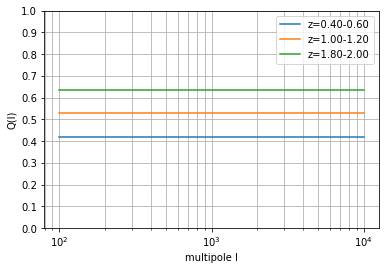

In [7]:
Q2=get_Q_function(2,Del_mg,Del_l_list,z_list)
Q5=get_Q_function(5,Del_mg,Del_l_list,z_list)
Q9=get_Q_function(9,Del_mg,Del_l_list,z_list)

plt.figure()
plt.plot(Del_l_list, Q2,label='z=%1.2f-%1.2f'%(0.4,0.6))
plt.plot(Del_l_list, Q5,label='z=%1.2f-%1.2f'%(1.0,1.2))
plt.plot(Del_l_list, Q9,label='z=%1.2f-%1.2f'%(1.8,2.0))
plt.xlabel('multipole l')
plt.xscale('log')
plt.ylabel('Q(l)')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(True,axis='both',which='both')
plt.legend()
plt.show()